# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.767470,False,-4.425477
1,0.935056,True,7.371393
2,0.706875,True,9.480024
3,-0.186815,False,-0.162630
4,2.063223,True,10.379609
...,...,...,...
995,0.928645,True,8.088187
996,1.181780,True,9.637530
997,0.112258,True,4.141375
998,1.027307,True,6.947324


<AxesSubplot: xlabel='v0'>

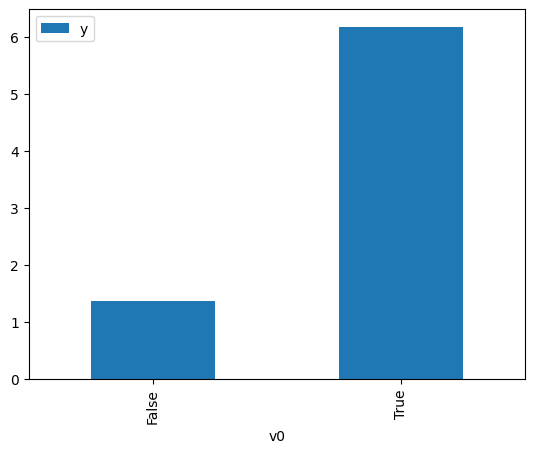

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

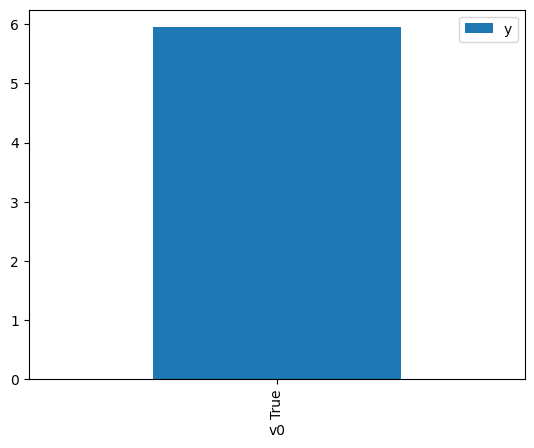

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.122192,False,0.248470,0.595881,1.678187
1,-0.145728,False,-0.765122,0.608696,1.642858
2,0.794498,False,2.041888,0.155058,6.449180
3,-1.147267,False,-1.411206,0.938110,1.065973
4,-1.368714,False,-3.508937,0.961650,1.039879
...,...,...,...,...,...
995,-0.252028,False,-1.857520,0.664513,1.504861
996,1.259455,False,3.212320,0.059952,16.680135
997,0.340491,False,-0.207070,0.339970,2.941435
998,0.832908,False,1.560564,0.143960,6.946358


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.205223,True,5.520259,0.359606,2.780825
1,-0.676324,True,2.020135,0.161383,6.196433
2,2.223769,True,10.091707,0.992928,1.007123
3,0.514145,True,6.012353,0.742342,1.347089
4,0.795988,True,8.248792,0.845385,1.182893
...,...,...,...,...,...
995,0.544053,True,4.722093,0.755129,1.324276
996,-0.842433,True,3.162533,0.116545,8.580399
997,1.416302,True,8.819058,0.957260,1.044648
998,1.722746,True,6.690068,0.978237,1.022247


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.729e+04
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        06:25:28   Log-Likelihood:                         -1452.2
No. Observations:                1000   AIC:                                      2908.
Df Residuals:                     998   BIC:                                      2918.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4271      0.041     59.279      0.000       2.347       2.507
x2             4.9769      0.056     88.382      0.000       4.866       5.087
==============================================================================
Omnibus:                        0.250   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.883   Jarque-Bera (JB):                0.264
Skew:                          -0.038   Prob(JB):                        0.876
Kurtosis:                       2.979   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""